In [21]:
# Install required packages
!pip install opencv-python onnxruntime pillow numpy matplotlib

# Import libraries
import cv2
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import os

In [11]:
# Load YOLOv8 ONNX model
model_path = r"C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\best.onnx"
session = ort.InferenceSession(model_path)

# Get model input/output info
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
input_shape = session.get_inputs()[0].shape

print(f"Model input name: {input_name}")
print(f"Model input shape: {input_shape}")
print(f"Model output name: {output_name}")

Model input name: images
Model input shape: [1, 3, 640, 640]
Model output name: output0


In [12]:
def preprocess_image(image_path, input_size=(640, 640)):
    """
    Preprocess image for YOLOv8 inference
    """
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get original dimensions
    orig_height, orig_width = image_rgb.shape[:2]
    
    # Resize image
    resized = cv2.resize(image_rgb, input_size)
    
    # Normalize to [0, 1] and convert to float32
    input_image = resized.astype(np.float32) / 255.0
    
    # Change from HWC to CHW format
    input_image = np.transpose(input_image, (2, 0, 1))
    
    # Add batch dimension
    input_image = np.expand_dims(input_image, axis=0)
    
    return input_image, image_rgb, (orig_width, orig_height)

In [13]:
def postprocess_output(output, orig_size, input_size=(640, 640), conf_threshold=0.5, iou_threshold=0.4):
    """
    Postprocess YOLOv8 output
    """
    orig_width, orig_height = orig_size
    input_width, input_height = input_size
    
    # Get output array
    predictions = output[0]
    
    # YOLOv8 output format: [batch, 84, 8400] where 84 = 4(bbox) + 80(classes)
    # Transpose to [batch, 8400, 84]
    predictions = np.transpose(predictions, (0, 2, 1))
    
    boxes = []
    scores = []
    class_ids = []
    
    # Scale factors
    x_scale = orig_width / input_width
    y_scale = orig_height / input_height
    
    for prediction in predictions[0]:
        # Extract bbox coordinates (center_x, center_y, width, height)
        center_x, center_y, width, height = prediction[0:4]
        
        # Extract class scores
        class_scores = prediction[4:]
        class_id = np.argmax(class_scores)
        confidence = class_scores[class_id]
        
        if confidence >= conf_threshold:
            # Convert center format to corner format
            x1 = int((center_x - width / 2) * x_scale)
            y1 = int((center_y - height / 2) * y_scale)
            x2 = int((center_x + width / 2) * x_scale)
            y2 = int((center_y + height / 2) * y_scale)
            
            boxes.append([x1, y1, x2, y2])
            scores.append(float(confidence))
            class_ids.append(int(class_id))
    
    # Apply Non-Maximum Suppression
    if len(boxes) > 0:
        boxes = np.array(boxes)
        scores = np.array(scores)
        
        # OpenCV NMS
        indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), conf_threshold, iou_threshold)
        
        if len(indices) > 0:
            if isinstance(indices, np.ndarray):
                indices = indices.flatten()
            
            final_boxes = boxes[indices]
            final_scores = scores[indices]
            final_class_ids = [class_ids[i] for i in indices]
            
            return final_boxes, final_scores, final_class_ids
    
    return [], [], []

In [14]:
def draw_detections(image, boxes, scores, class_ids, class_names=None):
    """
    Draw detection results on image
    """
    image_copy = image.copy()
    
    # Define colors for different classes
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
        (0, 255, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0)
    ]
    
    for i, (box, score, class_id) in enumerate(zip(boxes, scores, class_ids)):
        x1, y1, x2, y2 = box
        color = colors[class_id % len(colors)]
        
        # Draw bounding box
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), color, 2)
        
        # Prepare label
        if class_names and class_id < len(class_names):
            label = f"{class_names[class_id]}: {score:.2f}"
        else:
            label = f"Class {class_id}: {score:.2f}"
        
        # Draw label background
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(image_copy, (x1, y1 - label_size[1] - 10), 
                     (x1 + label_size[0], y1), color, -1)
        
        # Draw label text
        cv2.putText(image_copy, label, (x1, y1 - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    return image_copy

In [15]:
def detect_objects(image_path, model_session):
    """
    Main function to detect objects in image
    """
    # Preprocess image
    input_image, original_image, orig_size = preprocess_image(image_path)
    
    # Run inference
    input_name = model_session.get_inputs()[0].name
    output = model_session.run(None, {input_name: input_image})
    
    # Postprocess output
    boxes, scores, class_ids = postprocess_output(output, orig_size)
    
    return boxes, scores, class_ids, original_image

In [18]:
# Path to your image
image_path = r"C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\4x.jpg"

# Check if files exist
if not os.path.exists(model_path):
    print(f"Model file not found: {model_path}")
elif not os.path.exists(image_path):
    print(f"Image file not found: {image_path}")
else:
    print("Running detection...")
    
    # Run detection
    boxes, scores, class_ids, original_image = detect_objects(image_path, session)
    
    print(f"Detected {len(boxes)} objects:")
    for i, (box, score, class_id) in enumerate(zip(boxes, scores, class_ids)):
        print(f"  Object {i+1}: Class {class_id}, Confidence: {score:.3f}, Box: {box}")

Running detection...
Detected 1 objects:
  Object 1: Class 0, Confidence: 0.677, Box: [275 264 315 295]


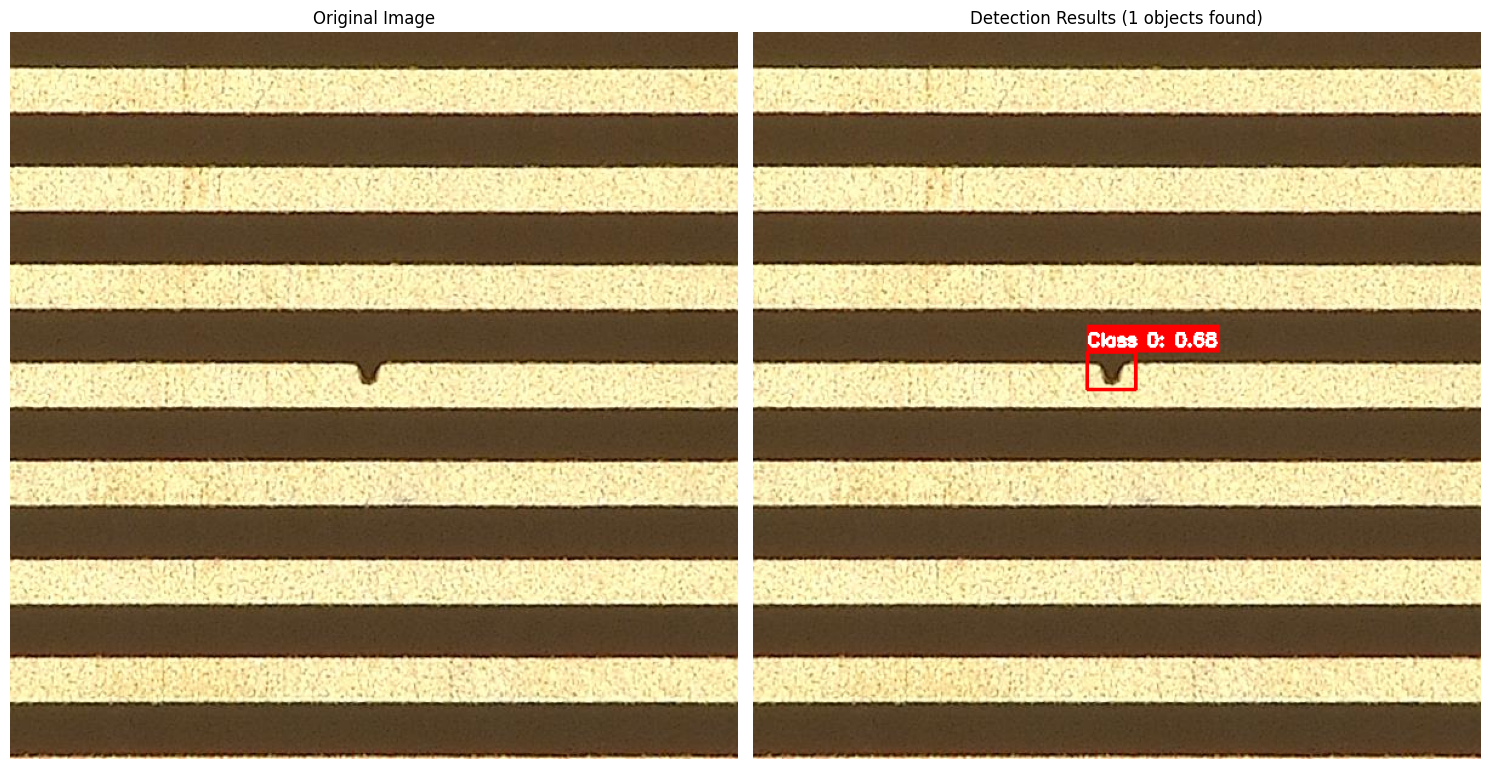

Result saved to: C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\4x.jpg


In [19]:
# Draw detections on image
if len(boxes) > 0:
    result_image = draw_detections(original_image, boxes, scores, class_ids)
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Detection results
    plt.subplot(1, 2, 2)
    plt.imshow(result_image)
    plt.title(f"Detection Results ({len(boxes)} objects found)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save result
    result_path = r"C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\4x.jpg"
    result_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(result_path, result_bgr)
    print(f"Result saved to: {result_path}")
    
else:
    plt.figure(figsize=(8, 6))
    plt.imshow(original_image)
    plt.title("No objects detected")
    plt.axis('off')
    plt.show()

In [22]:
# Simple camera display - no AI detection
import cv2
import time

def show_camera():
    """
    Hiển thị camera đơn giản
    """
    # Mở camera (0 là camera mặc định)
    cap = cv2.VideoCapture(0)
    
    # Kiểm tra camera có mở được không
    if not cap.isOpened():
        print("❌ Không thể mở camera!")
        print("Hãy kiểm tra:")
        print("1. Camera có được kết nối không?")
        print("2. Có ứng dụng nào khác đang sử dụng camera không?")
        return
    
    print("✅ Camera đã mở thành công!")
    print("📝 Hướng dẫn:")
    print("  - Nhấn 'q' để thoát")
    print("  - Nhấn 's' để chụp ảnh")
    
    # Đặt kích thước camera
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    frame_count = 0
    
    try:
        while True:
            # Đọc frame từ camera
            ret, frame = cap.read()
            
            if not ret:
                print("❌ Không thể đọc frame từ camera")
                break
            
            frame_count += 1
            
            # Lật ngược frame để có hiệu ứng gương
            frame = cv2.flip(frame, 1)
            
            # Thêm thông tin lên frame
            current_time = time.strftime("%H:%M:%S")
            cv2.putText(frame, f"Time: {current_time}", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, f"Frame: {frame_count}", (10, 60), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, "Press 'q' to quit, 's' to save", (10, 90), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
            # Hiển thị frame
            cv2.imshow('Live Camera', frame)
            
            # Xử lý phím bấm
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('q'):
                print("🛑 Đang thoát...")
                break
            elif key == ord('s'):
                # Lưu ảnh hiện tại
                filename = f"captured_{int(time.time())}.jpg"
                cv2.imwrite(filename, frame)
                print(f"📸 Đã lưu ảnh: {filename}")
    
    except KeyboardInterrupt:
        print("🛑 Dừng bởi người dùng")
    
    finally:
        # Giải phóng tài nguyên
        cap.release()
        cv2.destroyAllWindows()
        print("✅ Đã đóng camera")

# Gọi hàm để hiển thị camera
show_camera()

✅ Camera đã mở thành công!
📝 Hướng dẫn:
  - Nhấn 'q' để thoát
  - Nhấn 's' để chụp ảnh
📸 Đã lưu ảnh: captured_1753850043.jpg
🛑 Đang thoát...
✅ Đã đóng camera


🚀 Bắt đầu human detection...
🔍 Đang phân tích ảnh: C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\4x.jpg
👥 Tìm thấy 0 người trong ảnh


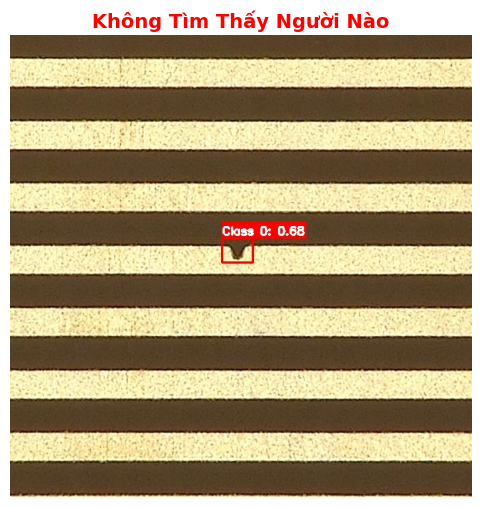

👤 Không phát hiện được người nào trong ảnh
✅ Hoàn thành human detection!


In [ ]:
import cv2
import numpy as np
import onnxruntime as ort
import os
import matplotlib.pyplot as plt

def preprocess_image(image_path, input_size=(640, 640)):
    """
    Tiền xử lý ảnh cho YOLOv8
    """
    # Đọc ảnh
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Không thể đọc ảnh: {image_path}")
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = image_rgb.shape[:2]
    
    # Resize về input size
    resized_image = cv2.resize(image_rgb, input_size)
    
    # Chuẩn hóa pixel values về [0, 1]
    normalized = resized_image.astype(np.float32) / 255.0
    
    # Chuyển từ HWC sang CHW format
    transposed = np.transpose(normalized, (2, 0, 1))
    
    # Thêm batch dimension
    input_tensor = np.expand_dims(transposed, axis=0)
    
    return input_tensor, image_rgb, (original_width, original_height)

def postprocess_detections(outputs, original_size, input_size=(640, 640), conf_threshold=0.5, person_class_id=0):
    """
    Xử lý output từ YOLOv8 và lọc chỉ lấy class 'person'
    """
    original_width, original_height = original_size
    input_width, input_height = input_size
    
    # YOLOv8 output shape: [1, 84, 8400]
    predictions = outputs[0]
    
    # Transpose thành [1, 8400, 84]
    predictions = np.transpose(predictions, (0, 2, 1))
    
    detections = []
    scale_x = original_width / input_width
    scale_y = original_height / input_height
    
    for detection in predictions[0]:
        # Lấy bbox coordinates (center_x, center_y, width, height)
        center_x, center_y, width, height = detection[:4]
        
        # Lấy class confidences
        class_scores = detection[4:]
        class_id = np.argmax(class_scores)
        confidence = class_scores[class_id]
        
        # Chỉ lấy detections của class 'person' với confidence cao
        if class_id == person_class_id and confidence >= conf_threshold:
            # Chuyển về original scale
            x1 = int((center_x - width / 2) * scale_x)
            y1 = int((center_y - height / 2) * scale_y)
            x2 = int((center_x + width / 2) * scale_x)
            y2 = int((center_y + height / 2) * scale_y)
            
            # Đảm bảo bbox trong boundaries của ảnh
            x1 = max(0, min(x1, original_width))
            y1 = max(0, min(y1, original_height))
            x2 = max(0, min(x2, original_width))
            y2 = max(0, min(y2, original_height))
            
            detections.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': float(confidence),
                'class_id': int(class_id),
                'class_name': 'person'
            })
    
    # Apply Non-Maximum Suppression để loại bỏ duplicate detections
    if len(detections) > 0:
        boxes = np.array([det['bbox'] for det in detections])
        scores = np.array([det['confidence'] for det in detections])
        
        # OpenCV NMS
        indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), conf_threshold, 0.4)
        
        if len(indices) > 0:
            if isinstance(indices, np.ndarray):
                indices = indices.flatten()
            return [detections[i] for i in indices]
    
    return []

def draw_person_detections(image, detections):
    """
    Vẽ bounding boxes cho các person detections
    """
    image_copy = image.copy()
    
    for i, detection in enumerate(detections):
        bbox = detection['bbox']
        confidence = detection['confidence']
        
        x1, y1, x2, y2 = bbox
        
        # Vẽ bounding box màu xanh lá cho person
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Chuẩn bị label
        label = f"Person {i+1}: {confidence:.2f}"
        
        # Vẽ background cho label
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(image_copy, (x1, y1 - label_size[1] - 10), 
                     (x1 + label_size[0], y1), (0, 255, 0), -1)
        
        # Vẽ text label
        cv2.putText(image_copy, label, (x1, y1 - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        # Thêm thông tin kích thước person
        person_width = x2 - x1
        person_height = y2 - y1
        size_info = f"Size: {person_width}x{person_height}"
        cv2.putText(image_copy, size_info, (x1, y2 + 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
    
    return image_copy

def detect_humans_in_image(image_path, model_path):
    """
    Main function để detect người trong ảnh
    """
    print(f"🔍 Đang phân tích ảnh: {image_path}")
    
    # Kiểm tra file tồn tại
    if not os.path.exists(image_path):
        print(f"❌ File không tồn tại: {image_path}")
        return None, None, []
    
    if not os.path.exists(model_path):
        print(f"❌ Mô hình không tồn tại: {model_path}")
        return None, None, []
    
    try:
        # Load mô hình YOLOv8
        session = ort.InferenceSession(model_path)
        input_name = session.get_inputs()[0].name
        output_name = session.get_outputs()[0].name
        
        # Tiền xử lý ảnh
        input_tensor, original_image, original_size = preprocess_image(image_path)
        
        # Chạy inference
        outputs = session.run([output_name], {input_name: input_tensor})
        
        # Xử lý kết quả
        detections = postprocess_detections(outputs, original_size, person_class_id=0)
        
        print(f"👥 Tìm thấy {len(detections)} người trong ảnh")
        
        # In chi tiết từng detection
        for i, detection in enumerate(detections):
            bbox = detection['bbox']
            conf = detection['confidence']
            print(f"  👤 Người {i+1}: Confidence={conf:.3f}, BBox={bbox}")
        
        return original_image, detections, True
        
    except Exception as e:
        print(f"❌ Lỗi trong quá trình detection: {e}")
        return None, [], False

# Đường dẫn ảnh và mô hình
image_path = r"C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\x.jpg"
model_path = r"C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\yolov8n.onnx"

# Chạy detection
print("🚀 Bắt đầu human detection...")
print("=" * 50)

original_image, detections, success = detect_humans_in_image(image_path, model_path)

if success and original_image is not None:
    # Vẽ kết quả detection
    if len(detections) > 0:
        result_image = draw_person_detections(original_image, detections)
        
        # Hiển thị kết quả
        plt.figure(figsize=(15, 10))
        
        # Ảnh gốc
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title("Ảnh Gốc", fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Kết quả detection
        plt.subplot(1, 2, 2)
        plt.imshow(result_image)
        plt.title(f"Phát Hiện {len(detections)} Người", fontsize=14, fontweight='bold', color='green')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Lưu kết quả
        result_path = r"C:\Users\sonng\OneDrive\Desktop\APPAutoVRS\4x_human_detection.jpg"
        result_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(result_path, result_bgr)
        print(f"💾 Kết quả đã lưu: {result_path}")
        
    else:
        # Không tìm thấy người
        plt.figure(figsize=(8, 6))
        plt.imshow(original_image)
        plt.title("Không Tìm Thấy Người Nào", fontsize=14, fontweight='bold', color='red')
        plt.axis('off')
        plt.show()
        print("👤 Không phát hiện được người nào trong ảnh")
        
else:
    print("❌ Không thể xử lý ảnh")

print("=" * 50)
print("✅ Hoàn thành human detection!")